In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import networkx as nx
import tweepy
import pickle
import IPython.display as dp
import urllib.request
import io
from PIL import Image
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [2]:
with open('data/edges.bin', 'rb') as fp:
    edges = pickle.loads(fp.read())

with open('data/visited.bin', 'rb') as fp:
    visited = pickle.loads(fp.read())

with open('data/crawl_frontier.bin', 'rb') as fp:
    crawl_frontier = pickle.loads(fp.read())

In [3]:
g = nx.DiGraph()
g.add_edges_from(edges)

In [4]:
ranks = {}
ranks['pagerank'] = nx.pagerank(g)
# ranks['in_degree'] = nx.in_degree_centrality(g)
# ranks['closeness'] = nx.closeness_centrality(g)
# ranks['betweenness'] = nx.betweenness_centrality(g)

In [5]:
ranked = list(sorted(ranks['pagerank'], key=ranks['pagerank'].get, reverse=True))
g.remove_nodes_from(ranked[12:])
len(g.nodes())

12

In [6]:
import config
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token_key, config.access_token_secret)
api = tweepy.API(auth)

In [7]:
# get screen_name and image
for user_id in g.nodes():
    status = api.get_user(user_id)
    g.node[user_id]['screen_name'] = status.screen_name
    g.node[user_id]['image_url'] = status.profile_image_url
    file = io.BytesIO(urllib.request.urlopen(status.profile_image_url).read())
    g.node[user_id]['image']= Image.open(file)

visited: 628


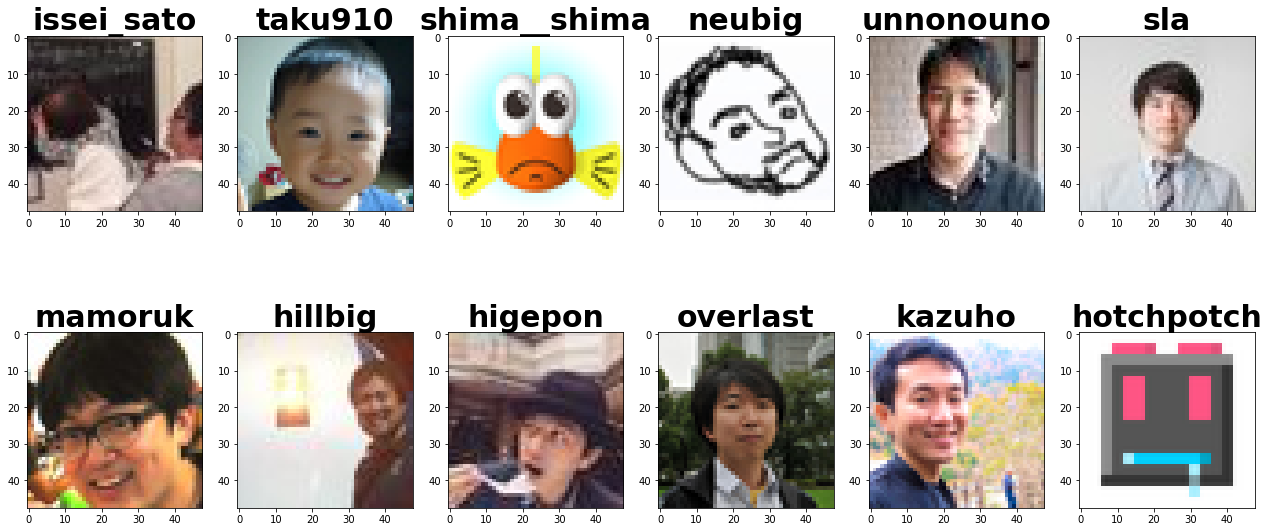

In [8]:
g.node[g.nodes()[0]]['image']
print('visited: %d' % len(visited))

plt.subplots(2, 6, figsize=(22, 10))

cnt = 1
for user_id in g.nodes():
    plt.subplot(2, 6, cnt)
    plt.title(s=g.node[user_id]['screen_name'], fontsize=30, fontweight='bold')
    plt.imshow(g.node[user_id]['image'])
    cnt += 1

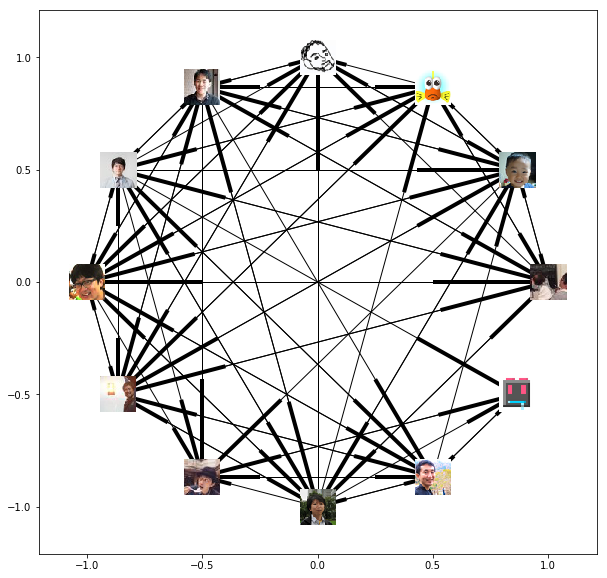

In [9]:
# pos = nx.spring_layout(g)
pos = nx.circular_layout(g)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
nx.draw_networkx_edges(g, pos, ax=ax, arrows=True, zorder=10)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

piesize=0.05 # this is the image size
p2=piesize/2.0
for user_id in g.nodes():
   xa, ya = trans2(trans(pos[user_id]))
   a = plt.axes([xa-p2,ya-p2, piesize, piesize])
   a.imshow(g.node[user_id]['image'], zorder=1)
   a.axis('off')

In [ ]:
# pos = nx.spring_layout(g)
pos = nx.circular_layout(g)

Xv = [v[0] for v in pos.values()]
Yv = [v[1] for v in pos.values()]
Xed = np.array([[pos[edge[0]][0], pos[edge[1]][0]] for edge in g.edges()]).flatten()
Yed = np.array([[pos[edge[0]][1], pos[edge[1]][1]] for edge in g.edges()]).flatten()
labels = g.nodes()

trace1=go.Scatter(x=Xed,
                  y=Yed,
                  mode='lines',
                  line=go.Line(width=0.5,color='#888'),
                  name='follow',
                  hoverinfo='none'
)
trace2=go.Scatter(x=Xv,
                  y=Yv,
                  mode='markers',
                  name='users',
                  marker=go.Marker(symbol='dot', color='red', size=20),
                  text=labels,
                  hoverinfo='text'
)

images = [{"source": g.node[user_id]['image_url'], 
           "x": pos[user_id][0]/2.3 + 0.48, 
           "y": pos[user_id][1]/2.3 + 0.55, 
           "sizex": 0.1, 
           "sizey": 0.1,
           } for user_id in g.nodes()]
        
layout= go.Layout(images=images)
fig=go.Figure(data=[trace1, trace2], layout=layout)
plotly.offline.iplot(fig)